In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *

### Diff in Diff Plot Function

In [2]:
def diff_in_diff_plot(df_treatment, df_control, policy_implementation_year, resp_variable, file_name):
    
    df_treatment['standardized_year'] = df_treatment['Year'] - policy_implementation_year
    df_control['standardized_year'] = df_control['Year'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    
    plot = (
        ggplot() +
        geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
        geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 

        geom_smooth(df_control[df_control['standardized_year'] < 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
        geom_smooth(df_control[df_control['standardized_year'] >= 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm')
        + geom_vline(xintercept = 0) 
        + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) 
        + '. \nRepresented as "0" on the x-axis.') 
        + ylab(str('State GDP') + ' \n(Adding 95% confidence interval)')
        + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
        + labs(title=str("Difference in Difference Plot "))

    )
    
    # Save plot to images folder.
    ggsave(filename=str('../20_intermediate_files/images/'+file_name),
           plot=plot,
           dpi=150,
           height=8,
           width=8,
           verbose = False)

    
    return plot


### Pre-Post Plot Function

In [3]:
def pre_post_plot(df_treatment, policy_implementation_year, resp_variable, file_name):
    df_treatment['standardized_year'] = df_treatment['Year'] - policy_implementation_year
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm')
    + geom_vline(xintercept = 0) 
    + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) 
    + '. \nRepresented as "0" on the x-axis.') 
    + ylab(str(resp_variable) + ' \n(Adding 95% confidence interval)')
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
    + labs(title=str("Pre Post Plot"))
    )
    # Save plot to images folder.
    ggsave(filename=str('../20_intermediate_files/images/pre_post_'+file_name),
           plot=plot,
           dpi=150,
           height=8,
           width=8,
           verbose = False)
    return plot

## Load Dataset

In [4]:
df = pd.read_csv('../20_intermediate_files/final_dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df['treatment'] = pd.Categorical(df['treatment'])

plot_df_treated = df[df['treatment'] == 1].copy()
plot_df_control = df[df['treatment'] == 0].copy()

### Pre-Post: Plot GDP vs Time

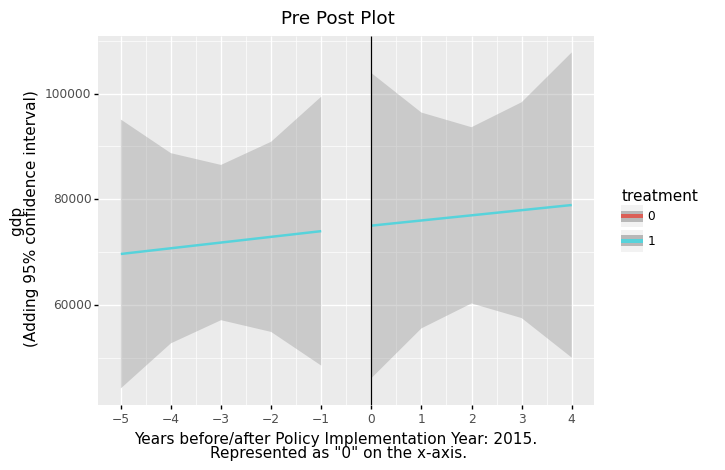

<ggplot: (8786270051190)>

In [5]:
# Min wages between treatment and control split in 2015.
policy_implementation_year = 2015
resp_variable = 'gdp'
file_name = 'GDP_vs_Time_Pre_Post'
plot = pre_post_plot(plot_df_treated, policy_implementation_year, resp_variable, file_name)
plot

### Diff-in-diff: Plot UnemploymentRate vs Time

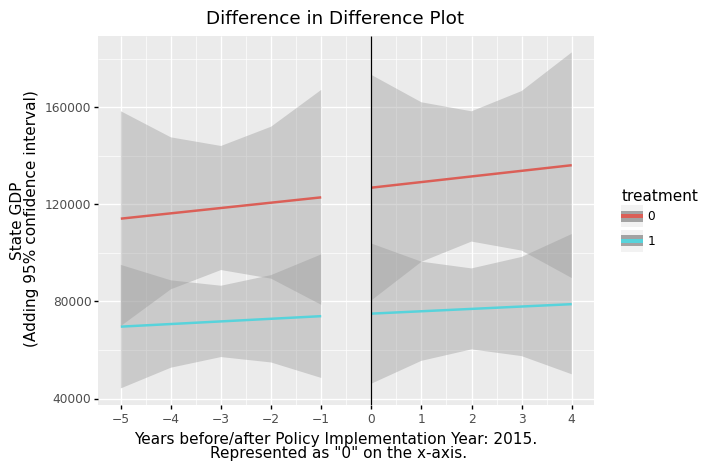

<ggplot: (8786270518775)>

In [6]:
# Min wages between treatment and control split in 2015.
policy_implementation_year = 2015
resp_variable = 'gdp'
file_name = 'GDP_vs_Time'
plot = diff_in_diff_plot(plot_df_treated, plot_df_control, policy_implementation_year, resp_variable, file_name)
plot

## Regression Analysis

### State Fixed Effects

In [7]:
#Add pre/post
pre = df[np.logical_and(df['Year'] >= 2010,df['Year'] <= 2014)].copy()
pre['Post'] = 0
post = df[np.logical_and(df['Year'] >= 2016,df['Year'] <= 2019)].copy()
post['Post'] = 1 

fe_df = pd.concat([pre, post])
fe_df.head()

,State,Year,FIPS_Code,Civilian_Pop,Civilian_Labor_Force,Labor_Force_Pct,Employed_Total,Employed_Pct,Unemployed_Total,Unemployed_Rate,Population,gdp,treatment,Post
0,Idaho,2010,16.0,1.165430e+06,762158.666667,65.408333,695375.583333,59.683333,66783.083333,8.758333,1570746.0,57952.9,0,0
1,Idaho,2011,16.0,1.179092e+06,764066.916667,64.800000,701595.750000,59.508333,62471.166667,8.166667,1583910.0,57825.3,0,0
2,Idaho,2012,16.0,1.193211e+06,772073.333333,64.708333,715011.583333,59.908333,57061.750000,7.400000,1595324.0,57780.1,0,0
3,Idaho,2013,16.0,1.208621e+06,777682.750000,64.350000,724710.750000,59.966667,52972.000000,6.816667,1611206.0,59966.8,0,0
4,Idaho,2014,16.0,1.226459e+06,777061.500000,63.358333,742988.166667,60.575000,34073.333333,4.383333,1631112.0,61663.2,0,0


In [8]:
model_fe = smf.ols('gdp ~ C(treatment) + C(Post) + C(treatment)*C(Post) + C(State) ', data=fe_df).fit()
model_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1265.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           2.30e-50
Time:                        19:44:50   Log-Likelihood:                -512.16
No. Observations:                  54   AIC:                             1040.
Df Residuals:                      46   BIC:                             1056.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       5.781e+04   1293.676     44.686      0.000    5.52e+04    6.04e+04
C(treatment)[T.1]               1.048e+04   1177.847      8.899      0.000    8110.831    1.29e+04
C(Post)[T.1]                    1.409e+04   1335.553     10.549      0.000    1.14e+04    1.68e+04
C(State)[T.Iowa]                9.909e+04   1625.584     60.958      0.000    9.58e+04    1.02e+05
C(State)[T.Kansas]              8.309e+04   1625.584     51.113      0.000    7.98e+04    8.64e+04
C(State)[T.Nebraska]            3.729e+04   1017.344     36.657      0.000    3.52e+04    3.93e+04
C(State)[T.South Dakota]       -2.612e+04   1017.344    -25.671      0.000   -2.82e+04   -2.41e+04
C(State)[T.West Virginia]       -695.0100   1017.344     -0.683      0.498   -2742.817    1352.797
C(treatment)[T.1]:C(Post)[T.1] -8567.2850   1888.758     -4.536      0.000   -1.24e+04   -4765.413
==============================================================================
Omnibus:                        1.083   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                0.429
Skew:                          -0.108   Prob(JB):                        0.807
Kurtosis:                       3.379   Cond. No.                     1.57e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.91e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""